In [1]:
import numpy as np
import math
import tensorflow as tf

import random
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

tf.test.gpu_device_name()

''

In [2]:
def ComputingErrorAgainstCheckingDataSet3D(PositionsChecking,ForcesChecking,NumberOfValuesToCompute,model):
    
    NN_calculations=model.predict(PositionsChecking[0:NumberOfValuesToCompute])
    T_matrix_calculations=ForcesChecking[0:NumberOfValuesToCompute]
    
    aux1=0
    for i in range (0,NumberOfValuesToCompute):
        aux2=0
        for j in range (0,3):
            aux2=aux2+(NN_calculations[i][j]-T_matrix_calculations[i][j])*(NN_calculations[i][j]-T_matrix_calculations[i][j])
        aux1=aux1+(np.sqrt(aux2))/NumberOfValuesToCompute
    return(aux1)

#We load the short file with the positions in meters
def LoadTranslationFile(NameTranslation):
    
    file1 = open(NameTranslation,"r")
    aux1=file1.readlines()
    Positions_meters=np.zeros(len(aux1))
    for i in range (0,len(aux1)):
        Positions_meters[i]=float(aux1[i])
    return (Positions_meters)

#We load the big file with the forces at different locations
def LoadDataFile(NameDataFile):
    
    file2 = open(NameDataFile,"r")
    aux2=file2.readlines()
    Matrix_Data=np.zeros([len(aux2),6])

    for i in range (0,len(aux2)):
        for j in range (0,6):
            Matrix_Data[i,j]=float((aux2[i]).split()[j])
    return(Matrix_Data)

def Translation(DataArray,TranslationArray):
    aux=len(DataArray)
    for i in range (0,aux):
        for j in range (0,3):
            DataArray[i,j]=TranslationArray[int(DataArray[i,j])-1]
    return(DataArray)

def UnitConversion(DataArray,PositionsFactor,ForcesFactor):
    aux=len(DataArray)
    DataArrayConv=DataArray
    for i in range (0,aux):
        for j in range (0,3):
                DataArrayConv[i][j]=PositionsFactor*DataArray[i][j]
    for i in range (0,aux):
        for j in range (3,6):
                DataArrayConv[i][j]=ForcesFactor*DataArray[i][j]
    return(DataArrayConv)
            
    
def Create3DForcesMatrix(Array_1D,dim):
    Matrix3D_Data=np.zeros([dim,dim,dim,3])
    for k in range (0,dim):
        for j in range (0,dim):
            for i in range (0,dim):
                for l in range (0,3):
                    Matrix3D_Data[i,j,k,l]=(float((np.split(Array_1D[int(k*dim*dim+j*dim+i)],6))[l+3]))
    return Matrix3D_Data

def Create3DPositionsMatrix(Array_1D,dim):
    Matrix3D_Data=np.zeros([dim,dim,dim,3])
    for k in range (0,dim):
        for j in range (0,dim):
            for i in range (0,dim):
                for l in range (0,3):
                    Matrix3D_Data[i,j,k,l]=(float((np.split(Array_1D[int(k*dim*dim+j*dim+i)],6))[l]))
    return Matrix3D_Data

def Create3DPositionsMatrixNoisy(Array_1D,desvest):
    Matrix3D_Data_Noisy=np.zeros([51,51,51,3])
    for k in range (0,51):
        for j in range (0,51):
            for i in range (0,51):
                for l in range (0,3):
                    Matrix3D_Data_Noisy[i,j,k,l]=(float((np.split(Array_1D[int(k*51*51+j*51+i)],6))[l+3]))+np.random.normal(0,desvest)
    return Matrix3D_Data_Noisy


def OrganizingDataForNN(DataArray,TrainingNumber,CheckingNumber,Desvest):
    
    np.random.shuffle(DataArray)

    Array_Positions=DataArray[0:len(DataArray),0:3]
    Array_Forces=DataArray[0:len(DataArray),3:6]

    Array_Positions_Training=Array_Positions[0:TrainingNumber,:]
    Array_Forces_Training=Array_Forces[0:TrainingNumber,:]+np.random.normal(0,Desvest)

    Array_Positions_Checking=Array_Positions[TrainingNumber:TrainingNumber+CheckingNumber,:]
    Array_Forces_Checking=Array_Forces[TrainingNumber:TrainingNumber+CheckingNumber,:]
    
    return([Array_Positions_Training,Array_Forces_Training,Array_Positions_Checking,Array_Forces_Checking])

In [3]:
my_file='C:\\Users\\David\\Desktop\\David\\Code\\NN_3DegreesOfFreedom\\NN20 Linear grid 100x100x100\\force_grid_3D'

In [4]:
my_file40='C:\\Users\\David\\Desktop\\David\\Code\\NN_3DegreesOfFreedom\\NN40 Linear grid 100x100x100\\force_grid_3D'

In [5]:
DataArrayRead=LoadDataFile(my_file+str(1)+'.txt')
for i in range (2,101):
    DataArrayRead=np.append(DataArrayRead,LoadDataFile(my_file+str(i)+'.txt'),axis=0)

In [6]:
DataArrayRead40=LoadDataFile(my_file40+str(1)+'.txt')
for i in range (2,101):
    DataArrayRead40=np.append(DataArrayRead40,LoadDataFile(my_file40+str(i)+'.txt'),axis=0)

In [7]:
len(DataArrayRead)

1000000

In [8]:
PositionsFactor=1E6
ForcesFactor=1E15

DataArray=UnitConversion(DataArrayRead,PositionsFactor,ForcesFactor)
DataArray40=UnitConversion(DataArrayRead40,PositionsFactor,ForcesFactor)


In [9]:
TrainingNumber=950000
CheckingNumber=50000
NumberOfValuesToCompute=50000

model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape = (3,)))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(3))

model.compile(optimizer=Adam(),loss='mse')

In [10]:
Desvest=0

DataForNN=OrganizingDataForNN(DataArray,TrainingNumber,CheckingNumber,Desvest)

Array_Positions_Training=DataForNN[0]
Array_Forces_Training=DataForNN[1]

Array_Positions_Checking=DataForNN[2]
Array_Forces_Checking=DataForNN[3]

Data40=OrganizingDataForNN(DataArray40,TrainingNumber,CheckingNumber,Desvest)

Array_Positions_Checking40=Data40[2]
Array_Forces_Checking40=Data40[3]

In [11]:
len(Array_Positions_Training)

950000

In [13]:
NofLoops=10000

Epochs=10
BatchSize=10000


Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 105439.5419
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 90499.6390
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 78605.9407
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 70396.0516
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 63696.5986
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 57986.1129
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 52995.0350
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 48545.0426
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 44535.6816
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 40925.9680
0
89.824185531621
68.02434876646355
INFO:ten

950000/950000 [==============================] - 2s 2us/sample - loss: 787.2397
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 714.5204
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 740.8048
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 768.9091
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 744.9045
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 731.7594
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 744.2548
15
37.82939676416126
39.26402926794975
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 738.4529
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 728.1936
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 718.3251
Epoch 4/10
950000/950000 [===========

950000/950000 [==============================] - 2s 2us/sample - loss: 544.6621
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 566.5182
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 579.4053
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 561.7005
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 560.6387
31
33.423842446128745
37.100670370854004
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 558.5132
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 568.9901
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 546.6145
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 539.2037
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 562.9648
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 489.4943
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 484.0188
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 496.1035
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 468.9239
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 494.9516
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 498.3615
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 502.8497
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 467.6190
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 486.1004
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 484.4143
48
31.678888672657745
36.59492229743859
Train on 950000 samples
Epoch 1/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 470.0999
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 474.5949
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 458.0599
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 448.9135
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 458.9064
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 461.6230
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 472.9539
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 463.2795
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 443.2860
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 470.4127
56
30.522304958048544
35.832490110299275
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 422.5372
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 449.2665
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 434.1958
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 443.2162
72
30.082738319311606
35.62914545848007
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 410.1432
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 436.4312
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 449.3823
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 420.9716
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 438.3188
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 417.8623
Epoch 7/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 403.1522
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 423.9434
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 392.8465
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 412.9266
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 416.2641
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 404.2610
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 393.0518
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 407.4070
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 412.9141
89
29.80319384102189
35.82060776605816
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 403.7494
Epoch 2/10
950000/950000 [===========

950000/950000 [==============================] - 2s 2us/sample - loss: 398.5105
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 389.3278
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 372.8018
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 389.3204
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 385.3048
105
30.02099115041693
36.023019617104104
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 389.1766
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 390.8495
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 378.8961
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 384.8520
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 393.8940
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 386.2951
113
29.132778686944324
35.64856137561297
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 367.6930
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 378.1461
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 384.0504
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 380.0320
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 388.0465
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 363.2007
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 384.4506
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 399.2969
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 360.8341
Epoch 10/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 366.4728
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 371.9737
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 365.7856
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 368.4175
130
29.019170693128277
35.53077523472462
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 364.0850
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 379.0760
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 361.5720
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 368.4085
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 373.2842
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 362.4713
Epoch 7/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 369.7838
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 372.4782
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 361.4689
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 381.9902
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 356.1005
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 364.5769
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 359.1529
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 363.6505
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 361.7196
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 355.9583
139
29.803492734724625
36.173141969086295
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 354.7020
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 352.7508
155
28.720654219762633
35.39409415576215
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 353.5811
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 367.4578
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 351.3423
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 357.2258
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 346.1651
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 362.6821
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 352.8188
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 365.8099
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 347.8534
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 363.8480
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 345.8720
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 345.8329
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 352.1146
172
28.338698245133745
35.38000847665607
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 348.1683
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 342.7963
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 344.5158
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 348.4965
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 345.2952
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 340.4308
180
28.779327233660144
35.57114908322771
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 353.2207
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 333.1297
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 354.0908
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 344.4227
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 343.4007
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 347.3547
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 339.8340
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 345.1083
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 347.0943
Epoch 10/10
950000/950000 [=========

950000/950000 [==============================] - ETA: 0s - loss: 344.810 - 2s 2us/sample - loss: 344.5046
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 338.8612
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 341.7707
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 344.1717
197
28.3580282803828
35.27046517594319
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 345.0671
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 338.7169
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 343.9923
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 332.8339
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 338.8816
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 347.3418
Epoch 7/10


950000/950000 [==============================] - 2s 2us/sample - loss: 328.3019
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 329.5129
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 336.6700
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 336.0964
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 347.0326
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 328.1519
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 344.4014
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 336.5018
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 334.6826
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 337.5020
206
28.83655122321663
35.90440176243513
Train on 950000 samples
Epoch 1/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 332.8750
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 342.8975
222
28.285941299383634
35.59803329328427
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 322.8517
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 339.3511
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 334.0688
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 331.1971
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 334.5901
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 328.4734
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 337.5299
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 328.0266
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 329.1002
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 324.3915
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 334.0618
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 325.1197
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 334.0790
239
28.55929740995442
35.80924811242632
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 331.5186
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.9129
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 330.3752
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 321.6261
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 331.1271
Epoch 6/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 328.6127
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 319.8940
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 334.8122
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 316.5403
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 328.8531
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 325.2161
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 328.7441
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 318.6613
256
28.193165377078042
35.5515775220996
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 332.1589
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 318.3119
Epoch 3/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 332.0981
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 311.8440
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 322.8445
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.6780
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 319.6722
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 321.3670
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 325.6197
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 322.8128
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 324.7695
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 322.4527
273
28.033311094303567
35.468401218403784
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 328.4408
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 319.3702
289
28.372014129352667
35.99794813597993
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 313.8683
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 331.6549
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 311.5168
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 321.5969
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 320.3129
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 320.2558
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.4116
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 319.8335
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 313.2943
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 324.9081
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 306.6650
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 327.1270
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 310.4645
306
27.979680022624528
35.801263237490936
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 321.9453
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.0273
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 310.2110
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 316.1118
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 322.1524
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 321.7728
314
29.144016242976775
36.624071922679605
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.9693
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 313.1872
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 326.7502
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 307.8435
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 326.0607
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 314.5597
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 308.8284
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 318.2781
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.7367
Epoch 10/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 313.5951
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 313.1686
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 318.0233
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 311.3328
331
27.78465180052165
35.51999847370831
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 310.4684
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.2313
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 307.5909
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 310.4825
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 312.7061
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 318.2741
Epoch 7/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 322.3738
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 309.2273
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 307.6356
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 319.7111
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 317.8532
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.2590
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 313.1596
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 304.7168
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.1265
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 307.9581
340
27.798895695579557
35.55453540051735
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 306.7278
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 318.1421
356
28.226076841796115
35.8373965203217
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 310.8914
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.8814
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 324.2307
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.5296
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 323.9599
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 306.6823
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 313.8491
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.5231
Epoch 9/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 301.7589
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 309.1842
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 316.3740
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 307.3458
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 305.2093
373
27.716421730816784
35.71812395898499
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 307.4392
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 316.1375
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 300.2870
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 313.5042
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 307.4791
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 308.4886
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 308.2611
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 305.8419
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.2941
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 306.3973
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 308.2681
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 313.8235
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 298.5745
390
27.99854146693835
35.88454220806452
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 308.6583
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 305.6241
Epoch 3/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 307.5662
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 307.6283
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.5548
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.2789
398
28.700035615542447
36.752499301519805
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 305.5086
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.9319
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 319.2616
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 302.1860
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 308.1838
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 317.2506
Epoch 7/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 302.5413
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 304.3493
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 308.7006
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 300.9626
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 302.8072
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 309.7806
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.5126
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 310.5928
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 298.0876
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 306.1227
407
27.61821975865355
35.64972948468704
Train on 950000 samples
Epoch 1/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 305.9408
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.7977
423
27.851786420333625
35.86072541943816
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.5471
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 305.6266
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.1366
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 305.1612
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 309.5585
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 300.7056
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 300.5776
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.2340
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 305.5315
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 306.7408
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 300.8260
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.0952
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.6442
440
27.802244147297277
35.89783861047096
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.5536
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.2619
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 311.2362
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.3992
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.1783
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 298.3813
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 311.3137
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.7911
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 302.2645
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.9046
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 310.7412
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.2317
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 302.6700
457
27.574376036920256
35.814158094934776
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 302.9541
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 300.8162
Epoch 3/10
950000/950000 [========

950000/950000 [==============================] - 3s 4us/sample - loss: 291.7094
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 310.5523
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.5640
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 304.1207
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.8445
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.4651
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.2235
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.1652
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 309.9217
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.6876
474
27.510420614799088
35.941697331599514
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 297.3582
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 306.1084
490
27.74165433908661
35.92403707131463
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.6053
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.4090
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.4939
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 302.6017
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.4203
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 298.1761
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.2677
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 300.6805
Epoch 9/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 298.2996
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.8965
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 298.6687
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.3472
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.7212
507
27.502203094498086
35.80183299867504
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.1464
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.0072
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.4850
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 300.3313
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.3918
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 297.0356
515
27.582198174139425
35.69949236258575
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 311.4250
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.9630
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.2127
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.2958
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.5845
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.8166
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.0740
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.0048
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.2129
Epoch 10/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 302.6981
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.8990
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.3104
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.5870
532
27.337034356407738
35.67294377891719
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.4697
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.0871
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.4566
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.1601
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.9600
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.0996
Epoch 7/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 290.9612
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.8760
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.3787
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.7955
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 305.4541
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.9548
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.8800
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 308.3967
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.0738
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.6672
541
27.543719551521626
35.85180641793245
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 292.3250
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.9136
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.9611
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 304.5462
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.5240
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.6051
549
27.432501435007275
35.728869958639734
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.4098
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.8725
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.3527
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.0027
Epoch 5/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 290.0706
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 304.2416
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.2280
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.1482
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.2943
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.5722
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.2344
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.2713
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 302.8215
566
27.312481451428965
35.64992734263626
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.7226
Epoch 2/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 294.6114
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.8188
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.7845
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.1778
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.9315
574
27.300653846864936
35.88920050295784
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 301.7524
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.8969
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.6304
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.7869
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.7832
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 292.0195
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.7864
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.7218
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.2599
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 298.0556
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.8100
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.3214
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.3445
591
27.41680806142808
35.6633910530706
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.7075
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.9561
Epoch 3/10
950000/950000 [===========

950000/950000 [==============================] - 2s 2us/sample - loss: 295.7021
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.9280
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 298.0815
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.0366
599
27.326918024705744
35.71243702952394
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.0614
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.5136
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.4869
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.0650
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 306.8545
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.6482
Epoch 7/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 286.4334
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.8200
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.1473
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.6653
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.1725
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.7749
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.3934
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.7216
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.7475
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.9731
608
27.378672091075966
35.73467438888641
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 290.3593
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.0872
624
27.35470833841622
35.80830268793569
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.1099
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.4055
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.2476
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.2831
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.1911
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.5411
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.6087
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.1621
Epoch 9/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 300.7807
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.7272
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.7279
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.4030
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 298.8204
641
27.30869048894303
35.90756774878211
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.6148
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.0593
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.7664
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.8557
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 299.3471
Epoch 6/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 288.7680
649
27.573548536630348
36.04154647331895
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 298.5064
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.7146
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.1513
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.8983
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.5312
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.7485
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.2823
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.7917
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.8514
Epoch 10/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 289.1450
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.8960
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.7106
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.7622
666
27.50060852899387
36.064140014809944
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 303.9599
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.9279
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.5960
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.7473
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.9372
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.7023
Epoch 7/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 288.7342
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.2322
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.9547
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.2484
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.5186
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.2893
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.4381
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.6015
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.5376
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.1305
675
27.382348267786053
35.85193371111049
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 286.3942
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.8282
691
27.35088656853528
35.92452473130297
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.5459
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.3238
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.2770
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.4900
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.6563
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.3690
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.6936
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.9471
Epoch 9/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 285.4910
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.7384
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.1253
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.4501
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.3077
708
27.912631205552017
36.425687579515504
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.6309
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.0028
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.3702
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.4161
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 297.6624
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 287.8353
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.2721
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.1493
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.9455
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.9121
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.4656
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.2885
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.5833
725
28.225152847187523
36.62342025983122
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.9442
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.0651
Epoch 3/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 287.4283
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.5208
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.2743
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.1857
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.3247
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.5086
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 296.6095
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.0241
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 295.6181
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.9068
742
27.39471820771101
35.99740080509788
Train on 950000 samples
Epoch 1/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 286.6331
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.8179
758
27.864637860591206
36.556685223626694
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.6867
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.7042
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.7511
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.8986
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.0368
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.3376
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 291.6316
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.5088
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 295.9751
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.5619
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.6048
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.8359
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.1174
775
27.312326834126566
35.78759490978611
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.7770
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.0306
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.7131
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.1808
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.5537
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 284.3096
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.9422
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.8088
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.4986
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 293.0025
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.0853
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.5354
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.8218
792
27.339805886355915
35.930754786279216
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.4453
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.9196
Epoch 3/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 287.7502
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.9064
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.4035
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.6780
800
27.387719140738312
35.84609547763243
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.5944
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.2473
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.0579
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.7188
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.7240
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.2220
Epoch 7/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 280.5492
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.9966
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.2922
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.4247
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.0307
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.3240
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.9385
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.0354
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.6593
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.5768
809
27.306407622108665
35.85378311826245
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 282.3879
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 292.1189
825
27.328439899008554
35.8585238486133
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.1945
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.8525
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.9673
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.1564
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.0953
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.5126
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.2791
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.1805
Epoch 9/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 284.9677
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.1536
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.3625
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.8292
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.5543
842
27.239895023231597
35.937266141529506
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.1583
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.4614
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.1957
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.4868
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.2701
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 283.8392
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.9217
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.8703
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.7967
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.2129
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.6714
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.4213
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.5158
859
27.38695580814238
36.10547395731641
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.3672
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.6305
Epoch 3/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 279.1001
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.3093
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.3002
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.5038
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.0240
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.5587
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.9780
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.9527
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.3711
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5229
876
27.46374123015597
36.275923258180114
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 280.3812
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.1750
892
27.453886551874664
36.17524736992251
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.2218
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.3690
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.3841
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.0904
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.7593
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.2652
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.6608
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.1876
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 281.3379
Epoch 7/10
950000/950000 [==============================] - 17s 17us/sample - loss: 284.7905
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.1182
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.0803
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.0281
909
27.19473835820772
35.89894266240641
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.4828
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.0537
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 294.2839
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3198
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.6249
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 281.5734
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.6753
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.4119
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.9115
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.2904
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.2272
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.3721
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.1476
926
27.465721941117707
36.19149140451918
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.7300
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.8588
Epoch 3/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 277.2800
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.1538
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9056
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.0575
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.7818
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.7361
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.9315
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.6767
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.5355
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.5425
943
27.181309487867566
36.00156529548993
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 281.4395
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.6339
959
27.485762913315018
36.031586999357025
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.6609
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.4613
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.6827
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.6815
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.1696
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.8891
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.5484
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.4970
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 284.2450
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.6247
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.1616
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3372
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.9062
976
28.388038390901823
36.89127571064251
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.4491
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.2646
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.2767
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.8850
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 288.6792
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 278.6866
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.8814
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.3844
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.5291
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.9776
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.5762
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.1588
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.3218
993
27.296020316096424
36.05229180808823
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.4814
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.9072
Epoch 3/10
950000/950000 [=========

1009
27.455897118563396
36.174388832401405
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.5120
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.3933
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.2146
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.1621
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.8323
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.5794
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.1163
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.0994
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.5965
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.8198
1010
27.17152964808837

950000/950000 [==============================] - 2s 2us/sample - loss: 280.0474
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.9761
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.3563
1026
27.19589372446802
35.85192532070644
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.5585
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0674
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.1199
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.7127
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.5393
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.1601
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.1015
Epoch 8/10
950000/950000 [=========

Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.9136
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.6088
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.0610
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.6368
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.1832
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 290.7324
1043
27.179783101728404
36.07964253341642
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.7783
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3145
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.6214
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.9442
Epoch 5/10
950000/95000

950000/950000 [==============================] - 2s 2us/sample - loss: 283.1667
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.0469
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.7774
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.7571
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.5934
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.8886
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.7988
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.0510
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.3746
1060
27.182631149012657
36.082192570429264
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.6428
Epoch 2/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 284.3005
1076
27.378643167166143
36.09988355544327
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.5373
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.5480
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.7709
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.1940
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.4062
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.0204
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0948
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.8828
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.2709
Epoch 10/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 277.4007
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.7994
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.2972
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.7630
1093
27.171990660998016
36.129548767702246
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.7100
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.5217
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.7449
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.4206
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.2803
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.6461
Epoch 7/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 281.2067
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.9227
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3483
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.4897
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.1763
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.6342
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.9961
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.6632
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.7722
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.6162
1102
27.06892420961058
35.95526028226275
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 280.4540
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.6402
1118
28.553980028850972
36.90856291943811
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.2021
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.2849
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.9211
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.8164
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.3372
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 289.0462
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6130
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.9933
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 277.7935
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.1393
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5764
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.1074
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.8806
1135
27.468196064597397
36.178826550664965
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.8622
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.2917
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 284.6444
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.4540
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.9213
Epoch 6/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 281.6701
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.9433
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.3552
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 287.4629
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8708
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.4057
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.6868
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.5941
1152
27.374991106457756
36.46124391999586
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.3080
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5163
Epoch 3/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 277.8709
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.1014
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3241
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9398
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.2146
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.9068
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8593
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.0390
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9584
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.6361
1169
27.190232082419705
36.29822900797349
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 278.4289
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.3289
1185
27.220948879369704
36.069463328595575
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.4854
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.9822
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.2813
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.0898
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.2391
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.5883
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.6060
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3186
Epoch 9/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 280.1664
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.1998
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.2569
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.2484
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.3835
1202
27.327793668316296
36.32582601159161
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.7184
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.8999
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.7131
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.3615
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.1648
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 278.0587
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.5422
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.0426
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.4966
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.8343
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.0145
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3547
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.6707
1219
27.138996867943334
36.1575514230487
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.4424
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.3992
Epoch 3/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 276.5256
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.7876
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.5976
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.5173
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.5678
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.2592
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.9568
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.0716
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.8850
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.7398
1236
27.553978895941885
36.511853259755895
Train on 950000 samples
Epoch 1/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 278.2146
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.8275
1252
27.714077598206725
36.78832837181254
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.7058
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3016
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.7039
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.8264
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.0440
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.9494
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.3218
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.7687
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 282.5195
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.4102
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.7974
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5231
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.3259
1269
27.135088685754425
36.14622500968751
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0894
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.8714
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7618
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.9106
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.3698
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 279.8737
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.5338
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.0777
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.7588
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.9518
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.2417
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.4159
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.0895
1286
27.66470065862213
36.47907529747927
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.9268
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.5161
Epoch 3/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 282.8562
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.1826
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8910
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5235
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.3618
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.3944
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0108
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3151
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.9215
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.6469
1303
27.80420636401229
36.6215663433059
Train on 950000 samples
Epoch 1/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 280.4086
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.3637
1319
27.13230070909577
36.25845317833103
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.0789
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9923
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.2930
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.8458
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0823
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.2026
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.4128
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.8297
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 274.8058
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.0488
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.6892
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.9161
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.8968
1336
27.293044168024494
36.355679505375214
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.5770
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.3230
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.2484
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3386
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.3498
Epoch 6/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 275.2599
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.8788
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.9477
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0291
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.4862
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.9312
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9188
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8180
1353
27.290528892497097
36.27349159865484
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.8171
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.8011
Epoch 3/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 275.6263
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.8359
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.0293
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5689
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.2735
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.4577
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.2210
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.5264
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.2221
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.6203
1370
27.12252482208161
36.21894720459591
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 272.9698
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.2378
1386
27.40001622583233
36.238614902087384
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.6649
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4931
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.7700
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.7014
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.5689
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.1473
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.5539
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.0353
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 273.6318
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9525
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.7292
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.0857
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.4111
1403
27.214777585294208
36.20628432825571
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.3383
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.8049
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.7826
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8624
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.5992
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 270.6896
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.2919
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.5186
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.6956
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.4340
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6407
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.9990
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8078
1420
27.09756036386431
36.12881765499027
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.4178
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.3664
Epoch 3/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 270.9504
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.6341
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9546
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.1265
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.4162
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.8961
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7571
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.2152
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8654
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 285.3933
1437
27.489716483366788
36.47964410418788
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 278.7107
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6930
1453
27.106730015381316
35.988858362211694
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8626
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.3633
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5743
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.2000
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.1038
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.6873
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.8903
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.1972
Epoch 9/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 276.0901
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9386
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.4962
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.5400
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.0248
1470
28.208890686788628
37.06257280931981
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.0752
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.1400
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0315
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.8400
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6204
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 277.8454
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.9626
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.2979
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.6471
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.1684
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.1014
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6380
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.7692
1487
27.131145551960586
36.225060619121024
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.7917
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.6005
Epoch 3/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 277.6663
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0889
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.8306
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.0796
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.5427
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.3058
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8953
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0642
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5597
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.7134
1504
27.306849083832017
36.44485525704713
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 274.9409
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.7212
1520
27.824907355798096
36.73765391339566
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.0185
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.8192
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.5728
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.2582
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0809
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7808
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.9219
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.4383
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 274.4635
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.0387
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.2323
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0427
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6318
1537
27.013960587464183
36.09851193185564
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.8912
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.0739
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.2551
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.0430
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0049
Epoch 6/10
950000/950000 [========

Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5317
1545
27.156359330431492
36.17152701415515
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.6326
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.5750
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.5004
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.4600
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.7985
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.4979
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0147
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4603
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.9071
Epoch 10/10
950000/9500

950000/950000 [==============================] - 2s 2us/sample - loss: 272.8298
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.6579
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8653
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.9275
1562
27.08373690523109
36.02582461803643
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.0636
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.1790
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.6828
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0809
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.0019
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9428
Epoch 7/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 272.3622
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.1698
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8640
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.9055
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.6221
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.1412
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.8959
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3958
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.7061
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0795
1571
27.18066037514682
36.31436932928911
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 275.1146
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0473
1587
27.29205382691614
36.433362179156504
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.9224
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.1223
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.4204
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.1932
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.1389
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.1344
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.3616
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.8043
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 272.5382
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.1719
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.2195
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.6731
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.8788
1604
27.525254708171875
36.6667460816316
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.2593
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8829
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.9709
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0662
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.6882
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 272.5879
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9811
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.5315
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.5442
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.3170
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.8770
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.7982
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3986
1621
27.20290905995133
36.326980079376014
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.4631
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.7408
Epoch 3/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 276.1688
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.5843
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.6433
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.3316
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.6719
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0460
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.7809
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7728
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.0761
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.3440
1638
27.064689295650048
36.14402040048928
Train on 950000 samples
Epoch 1/10
950000/950000 [========

Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.5418
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.8212
1654
27.48810803531591
36.651209102525826
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3036
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.2793
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8483
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.9510
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0417
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.0994
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4335
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.2756
Epoch 9/10
950000/95000

950000/950000 [==============================] - 2s 2us/sample - loss: 273.9135
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9898
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.7747
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8467
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.9596
1671
27.504489743055647
36.57809957718809
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.8396
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.6186
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4714
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 281.7231
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.4367
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 275.4260
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.0503
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.4040
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.8597
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.7986
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.1020
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.9453
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.3039
1688
27.169868777204545
36.281717473387445
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.2661
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0335
Epoch 3/10
950000/950000 [=======

Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9562
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9594
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0782
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.4636
1696
27.130583415823978
36.14277063914486
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.5492
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.3016
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.9337
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.5643
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.3809
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.1974
Epoch 7/10
950000/95000

950000/950000 [==============================] - 2s 2us/sample - loss: 271.3962
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0959
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.7471
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.2419
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8739
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.0783
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.2888
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.0580
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.9082
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.6983
1705
27.073482658922522
36.06962566906364
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 269.8016
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.5233
1721
27.110956820595973
36.29828338256632
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9940
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.5838
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.2210
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7556
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.6436
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.5226
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0781
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.9930
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 271.8307
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.1680
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.5946
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0248
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.5914
1738
27.089814873620035
36.21035731101074
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.5627
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.9901
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.1213
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.2334
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.1221
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 276.0947
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.0170
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.4570
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.2246
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.0004
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.2017
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.8377
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.5419
1755
27.250684485528065
36.500273371612415
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.7277
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.7095
Epoch 3/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 271.1345
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.2797
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.3400
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.3542
Epoch 5/10
950000/950000 [==============================] - ETA: 0s - loss: 270.925 - 2s 2us/sample - loss: 271.0869
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.0450
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.9963
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8311
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9358
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6497
1772
27.25849922747292
36.34823274748242
Train on 950000 samples
Epoch 1/1

950000/950000 [==============================] - 2s 2us/sample - loss: 272.8041
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.4414
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3754
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.9540
Epoch 9/10
950000/950000 [==============================] - 3s 4us/sample - loss: 274.0282
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.2693
1780
27.043968872616723
36.09507807042655
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4809
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.8631
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.0737
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.3658
Epoch 5/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 270.5471
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.9024
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.9794
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.9183
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.4981
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.9733
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.7587
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6500
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0266
1797
27.586231612596148
36.76763543745208
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.2018
Epoch 2/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 273.1170
1813
27.234273972579132
36.19246045383495
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.4342
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.8351
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 286.1537
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.3813
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8147
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.1364
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.7066
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.6959
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.2880
Epoch 10/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 274.1142
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.4949
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.4460
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.1519
1830
27.222951285944898
36.15996742010743
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.2798
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6582
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.1081
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.5611
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.1313
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.6889
Epoch 7/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 279.8401
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.7078
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.0497
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.1461
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.3942
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.4454
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.2704
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6975
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.5551
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.6261
1839
27.184103923185464
36.236229273147465
Train on 950000 samples
Epoch 1/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 278.4396
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.0353
1855
27.45871646767008
36.63372636731021
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0423
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.8625
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8710
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.5684
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.2365
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8872
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.4010
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.9509
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 276.2171
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.3571
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.5389
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.3843
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.2748
1872
27.111403756201117
36.11656418362451
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.5785
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 280.5103
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.6976
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.3482
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.2459
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 270.2234
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.4783
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.8016
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8409
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.5834
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.9847
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.9906
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.3348
1889
27.2169372254069
36.50082099025561
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.4941
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4039
Epoch 3/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 279.1010
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.9178
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.6984
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.4365
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.4088
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.4275
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.3087
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.2882
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.6235
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.0414
1906
27.126384617015905
36.3247034251888
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.8436
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.6131
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.6349
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 282.6575
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.0410
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.1194
1914
27.240677928683038
36.265319619639314
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.1518
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.3192
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8169
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.6095
Epoch 5/10
950000/9500

950000/950000 [==============================] - 2s 2us/sample - loss: 267.6462
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3996
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8028
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.9490
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.3416
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.5478
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0484
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.3335
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.5671
1931
27.046950695150876
36.08877727189857
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.1683
Epoch 2/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 272.5971
1947
27.042779684598084
36.341941631665044
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.6803
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.2777
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.6058
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.7759
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.9301
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.3797
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.1718
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.5408
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.4710
Epoch 10/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 269.6548
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.5826
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.9091
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.5819
1964
27.28376735975196
36.375324248718634
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.8102
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.9511
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.1179
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.6132
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.8150
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4589
Epoch 7/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 268.4544
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.2409
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.0009
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.0752
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.0043
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.4409
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0968
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.2261
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 278.9281
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.1096
1973
27.171103982757046
36.499400780993454
Train on 950000 samples
Epoch 1/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 268.1424
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.5698
1989
27.154986102405683
36.24190448342356
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.5851
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8673
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0302
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.2038
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.0921
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.7985
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.7304
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.7731
Epoch 9/10
950000/950000 [========

Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.1730
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.5574
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.5267
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.9935
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.8414
2006
27.15207515777306
36.17146029069869
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.6945
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.5011
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.5980
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.2954
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.8531
Epoch 6/10
950000/950000

950000/950000 [==============================] - 2s 2us/sample - loss: 275.3466
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.1138
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.3139
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.9325
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.8162
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 283.0333
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 265.9792
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.9789
2023
27.41928868649815
36.5209096322983
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.8598
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.2859
Epoch 3/10
950000/950000 [==========

950000/950000 [==============================] - 2s 2us/sample - loss: 271.4090
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.1344
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.7714
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.3101
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.3301
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0072
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.3826
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.6950
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.1050
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.2264
2040
27.202031362333052
36.26729061318763
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 266.5314
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4062
2056
28.073195555827706
37.23639896573916
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0240
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.1712
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.1931
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.3900
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.5870
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.6556
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.6250
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.6962
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 273.1821
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.4182
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.5551
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3807
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.6202
2073
27.18564727456724
36.16241865265251
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.4234
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.7748
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.5033
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.0866
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.6302
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 277.1362
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.4617
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3085
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.6655
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.4813
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.4058
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.6223
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.2271
2090
27.113018517974457
36.52887101927302
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.7686
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9274
Epoch 3/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 267.2771
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8785
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8228
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.7145
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.9523
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.4571
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.9255
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8587
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.8225
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.5108
2107
29.016337272448265
38.0998758880706
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 269.4403
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.3905
2123
27.41052358539993
36.50203631053323
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8529
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.4374
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.6705
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.8387
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.9789
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4004
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.3367
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.2500
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 271.0372
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.0448
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.0185
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.5078
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.5420
2140
27.23624414491952
36.48250174953651
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.0022
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.9840
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0644
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.7104
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.9030
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 281.2493
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.9540
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.3639
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.8587
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.2032
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.7528
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.5958
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.8095
2157
27.106803740992394
36.335180647365526
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.6476
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.4610
Epoch 3/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 267.0196
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.0168
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.5650
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7782
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.8436
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.3896
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.5601
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.6574
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.8603
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.5477
2174
27.150978024066376
36.50376853698929
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 270.2305
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.4543
2190
27.187849674863596
36.55803845366095
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.6595
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.1130
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.8780
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.2669
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.2858
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.7599
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.3531
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.0939
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 273.2768
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.2790
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.0568
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.0519
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.4660
2207
27.213498855051924
36.438042253619436
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3151
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.5749
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0865
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.3689
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0369
Epoch 6/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 265.9436
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.5327
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.1164
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.2268
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.6230
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.8885
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0471
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.7175
2224
27.137471729371402
36.45727389482245
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.9289
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.6730
Epoch 3/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 274.3286
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.3617
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.3031
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.1634
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.4697
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.0797
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.5347
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.5371
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.7657
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.4820
2241
27.14639374531951
36.31114963485489
Train on 950000 samples
Epoch 1/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 272.4200
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.2362
2257
28.03902159427383
37.10408294251225
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0531
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.6247
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.3921
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7960
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.7951
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.8274
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.4792
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.2966
Epoch 9/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 268.7202
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.8400
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 279.1624
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 264.9092
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.8720
2274
27.19195207572432
36.47816256069178
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.4119
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.7392
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3985
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.2031
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.2359
Epoch 6/10
950000/950000 [=========

950000/950000 [==============================] - 2s 2us/sample - loss: 269.5262
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.7826
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.3336
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.2536
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.9347
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.9075
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.7467
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.0402
2291
27.157039645774226
36.376256904916275
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.6186
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.6630
Epoch 3/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 266.9795
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.9436
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.5978
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.6470
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.6299
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.2546
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.1498
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.8133
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.5069
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.3709
2308
27.259248686268048
36.54526213333609
Train on 950000 samples
Epoch 1/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 271.4172
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.3590
2324
27.183335790442285
36.39003526732066
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 265.7653
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7234
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.0577
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 265.7659
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.7432
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 264.7008
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 277.7993
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 265.4777
Epoch 9/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 272.3564
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 271.4457
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 265.9738
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 275.9559
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 265.9819
2341
27.081582029394916
36.08756264806342
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.6632
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.6306
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.0912
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.0865
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 274.2867
Epoch 6/10
950000/950000 [========

950000/950000 [==============================] - 2s 2us/sample - loss: 268.6539
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.7877
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.3782
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.7508
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.8760
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.6049
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.3510
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.9922
2358
27.122853425562027
36.235450470379604
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.0285
Epoch 2/10
950000/950000 [==============================] - 3s 4us/sample - loss: 270.7939
Epoch 3/10
950000/950000 [=======

950000/950000 [==============================] - 2s 2us/sample - loss: 275.7806
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.8983
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.6150
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.8169
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.4458
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.5514
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.6725
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.8079
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.1787
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.6536
2375
27.559723450588052
36.81618789291604
Train on 950000 samples
Epoch 1/10
950000/950000 [========

Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.6326
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 270.2472
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.9885
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.2884
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.4556
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 266.6061
2383
27.181072497813936
36.427473683805964
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.9406
Epoch 2/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.6965
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.7757
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 272.5422
Epoch 5/10
950000/9500

950000/950000 [==============================] - 2s 2us/sample - loss: 270.3806
Epoch 3/10
950000/950000 [==============================] - 2s 2us/sample - loss: 265.7389
Epoch 4/10
950000/950000 [==============================] - 2s 2us/sample - loss: 276.1427
Epoch 5/10
950000/950000 [==============================] - 2s 2us/sample - loss: 265.7736
Epoch 6/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.7124
Epoch 7/10
950000/950000 [==============================] - 2s 2us/sample - loss: 269.9525
Epoch 8/10
950000/950000 [==============================] - 2s 2us/sample - loss: 268.3376
Epoch 9/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.7985
Epoch 10/10
950000/950000 [==============================] - 2s 2us/sample - loss: 273.8853
2400
27.262822999085884
36.50142754553474
Train on 950000 samples
Epoch 1/10
950000/950000 [==============================] - 2s 2us/sample - loss: 267.4352
Epoch 2/10
950000/950000 [========

KeyboardInterrupt: 

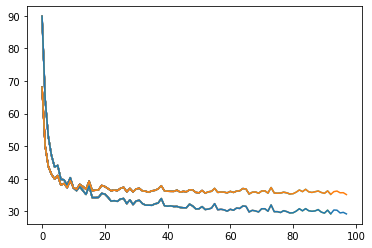

In [30]:
Errors20=np.zeros(NofLoops)
Errors40=np.zeros(NofLoops)


BestRecord=100
for i in range (0,NofLoops):
    
    hist = model.fit(Array_Positions_Training,Array_Forces_Training,validation_split=0,
    epochs= Epochs,
    batch_size=BatchSize)
    
    Errors20[i]=ComputingErrorAgainstCheckingDataSet3D(Array_Positions_Checking,Array_Forces_Checking,NumberOfValuesToCompute,model)
    Errors40[i]=ComputingErrorAgainstCheckingDataSet3D(Array_Positions_Checking40,Array_Forces_Checking40,NumberOfValuesToCompute,model)

    print(i)
    print(Errors20[i])
    print(Errors40[i])
    
    if Errors40[i]<BestRecord:    
        plt.plot(Errors20[0:i+1])
        plt.plot(Errors40[0:i+1])

        plt.savefig('C:\\Users\\David\\Desktop\\David\\Code\\NN_3DegreesOfFreedom\\Training\\20Rays_L3N256_500e2')
        model.save('C:\\Users\\David\\Desktop\\David\\Code\\NN_3DegreesOfFreedom\\Training\\20Rays_L3N256_500e2_'+str(Errors40[i]))
        BestRecord=Errors40[i]

In [ ]:
NameModelToSave='C:\\Users\\David\\Desktop\\David\\Code\\NN_3DegreesOfFreedom\\ModelTrained3L256N_40Rays_8.62'

model.save(NameModelToSave)